Deep Learning
=============

Assignment 4
------------

Previously in `2_fullyconnected.ipynb` and `3_regularization.ipynb`, we trained fully connected networks to classify [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) characters.

The goal of this assignment is make the neural network convolutional.

In [2]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
from load_and_generate import *

In [3]:
pickle_file = 'exploration.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (8432, 129, 23) (8432,)
Validation set (2811, 129, 23) (2811,)
Test set (2811, 129, 23) (2811,)


Reformat into a TensorFlow-friendly shape:
- convolutions need the image data formatted as a cube (width by height by #channels)
- labels as float 1-hot encodings.

In [4]:
image_size = 128
image_width = 23
image_height = 129

# ------------------
#image_width = 128
#image_height = 128

num_labels = 2
num_channels = 1 # grayscale

import numpy as np

def reformat(dataset, labels):
  dataset = dataset.reshape(
    (-1, image_height, image_width, num_channels)).astype(np.float32)
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (8432, 129, 23, 1) (8432, 2)
Validation set (2811, 129, 23, 1) (2811, 2)
Test set (2811, 129, 23, 1) (2811, 2)


In [5]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

Let's build a small network with two convolutional layers, followed by one fully connected layer. Convolutional networks are more expensive computationally, so we'll limit its depth and number of fully connected nodes.

In [7]:
batch_size = 20
patch_size = 3
depth = 16
num_hidden = 16
num_channels = 1
stride = 1 #very common

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_height, image_width, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
  #layer3_weights = tf.Variable(tf.truncated_normal(
  #    [image_height // 4 * image_width // 4 * depth, num_hidden], stddev=0.1)) #modified for variable height and width
  layer3_weights = tf.Variable(tf.truncated_normal(
      [(image_height // stride**2) * (image_width // stride**2) * depth, num_hidden], stddev=0.1)) #modified for variable height and width  
  #print (layer3_weights.get_shape().as_list())
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  # Model.
  def model(data):
    conv = tf.nn.conv2d(data, layer1_weights, [1, stride,stride, 1], padding='SAME')
    #print (conv.get_shape().as_list())
    hidden = tf.nn.relu(conv + layer1_biases)
    #print (hidden.get_shape().as_list())
    conv = tf.nn.conv2d(hidden, layer2_weights, [1, stride, stride, 1], padding='SAME')
    #print (conv.get_shape().as_list())
    hidden = tf.nn.relu(conv + layer2_biases)
    shape = hidden.get_shape().as_list()
    #print (hidden.get_shape().as_list())
    reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])    
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    return (tf.matmul(hidden, layer4_weights) + layer4_biases)
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [ ]:
num_steps = train_dataset.shape[0] // batch_size

#num_steps = 3001
print ("num_steps:%d" %num_steps)

valid_accuracy = []
test_accuracy = []
pred_step = []


with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 250 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
    if (step % 50 == 0):
      valid_accuracy.append(accuracy(
            valid_prediction.eval(), valid_labels))
      test_accuracy.append(accuracy(
            test_prediction.eval(), test_labels))
      pred_step.append(step)
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

num_steps:421
Initialized
Minibatch loss at step 0: 110.355690
Minibatch accuracy: 40.0%
Validation accuracy: 50.0%


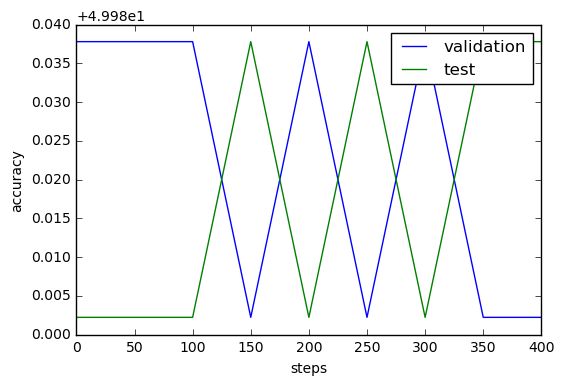

In [9]:
%matplotlib inline 
plt.plot(pred_step,valid_accuracy, label= 'validation')
plt.plot(pred_step,test_accuracy, label= 'test')
plt.xlabel('steps')
plt.ylabel('accuracy')
plt.legend()

---
Problem 1
---------

The convolutional model above uses convolutions with stride 2 to reduce the dimensionality. Replace the strides by a max pooling operation (`nn.max_pool()`) of stride 2 and kernel size 2.

---

In [39]:
batch_size = 16
patch_size = 2
depth = 16
num_hidden = 64
num_channels = 1
stride = 2


#---------------------
batch_size = 20
patch_size = 4
depth = 6
num_hidden = 32
num_channels = 1
stride = 4
pooling = 2

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_height, image_width, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
  #layer3_weights = tf.Variable(tf.truncated_normal(
  #    [image_height // 4 * image_width // 4 * depth, num_hidden], stddev=0.1)) #modified for variable height and width
  layer3_weights = tf.Variable(tf.truncated_normal(
      [(image_height // (stride**2*pooling**2)) * (image_width // (stride**2*pooling**2)) * depth, num_hidden], stddev=0.1)) #modified for variable height and width  

  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  # Model.
  def model(data):
    conv1 = tf.nn.conv2d(data, layer1_weights, [1, stride, stride, 1], padding='VALID')
    print (conv1.get_shape().as_list())
    hidden1 = tf.nn.relu(conv1 + layer1_biases)
    pool1 = tf.nn.max_pool(hidden1, ksize=[1, 2, 2, 1], strides=[1, pooling, pooling, 1], padding='SAME')
    print (pool1.get_shape().as_list())
    
    conv2 = tf.nn.conv2d(pool1, layer2_weights, [1, stride, stride, 1], padding='VALID')
    print (conv2.get_shape().as_list())
    hidden2 = tf.nn.relu(conv2 + layer2_biases)
    pool2 = tf.nn.max_pool(hidden2, ksize=[1, 2, 2, 1], strides=[1, pooling, pooling, 1], padding='SAME')    
    print (pool2.get_shape().as_list())
    
    shape = pool2.get_shape().as_list()

    reshape = tf.reshape(pool2, [shape[0], shape[1] * shape[2] * shape[3]])    
    hidden3 = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)

    return (tf.matmul(hidden3, layer4_weights) + layer4_biases)
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.3).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

[20, 32, 32, 6]
[20, 16, 16, 6]
[20, 4, 4, 6]
[20, 2, 2, 6]
[2811, 32, 32, 6]
[2811, 16, 16, 6]
[2811, 4, 4, 6]
[2811, 2, 2, 6]
[2811, 32, 32, 6]
[2811, 16, 16, 6]
[2811, 4, 4, 6]
[2811, 2, 2, 6]


In [40]:
num_steps = train_dataset.shape[0] // batch_size

#num_steps = 3001
print ("num_steps:%d" %num_steps)

valid_accuracy = []
test_accuracy = []
pred_step = []

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  for step in range(num_steps):
    #do not randomize train dataset each step: it is learning from slices and it will go mad!
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    #print ("offset %d" %offset)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 250 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
    if (step % 250 == 0):
      valid_accuracy.append(accuracy(
            valid_prediction.eval(), valid_labels))
      test_accuracy.append(accuracy(
            test_prediction.eval(), test_labels))
      pred_step.append(step)
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

num_steps:421
Initialized
Minibatch loss at step 0: 1.215984
Minibatch accuracy: 40.0%
Validation accuracy: 50.0%
Minibatch loss at step 250: 0.514865
Minibatch accuracy: 75.0%
Validation accuracy: 73.2%
Test accuracy: 78.4%


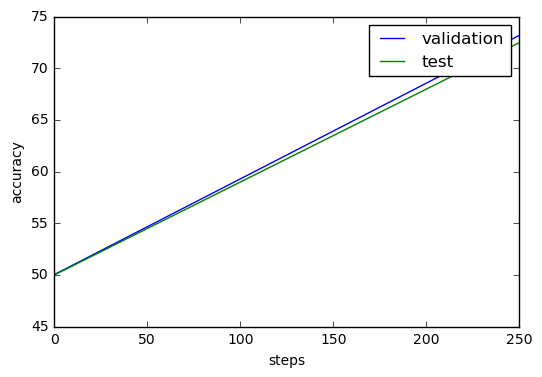

In [41]:
%matplotlib inline 
plt.plot(pred_step,valid_accuracy, label= 'validation')
plt.plot(pred_step,test_accuracy, label= 'test')
plt.xlabel('steps')
plt.ylabel('accuracy')
plt.legend()

In [167]:
num_steps = 1000

valid_accuracy = []
test_accuracy = []
pred_step = []

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  for batch_size in batch_array:
      for step in range(num_steps):
        #do not randomize train dataset each step: it is learning from slices and it will go mad!
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 50 == 0):
          print('Minibatch loss at step %d: %f' % (step, l))
          print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
          print('Validation accuracy: %.1f%%' % accuracy(
            valid_prediction.eval(), valid_labels))
          valid_accuracy.append(accuracy(
            valid_prediction.eval(), valid_labels))
          test_accuracy.append(accuracy(
            test_prediction.eval(), test_labels))
          pred_step.append(step)
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized


NameError: name 'batch_array' is not defined

---
Problem 2
---------

Try to get the best performance you can using a convolutional net. Look for example at the classic [LeNet5](http://yann.lecun.com/exdb/lenet/) architecture, adding Dropout, and/or adding learning rate decay.

---